In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from importlib import reload
import warnings
import wrangle as w
from evaluate import root_mean_squared_error
import model as m
from sklearn.linear_model import LinearRegression
import explore as e
from sklearn.preprocessing import MinMaxScaler,RobustScaler,PolynomialFeatures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter('ignore')

In [3]:
train,validate,test = w.wrangle_coasters()

<AxesSubplot: xlabel='length', ylabel='residual'>

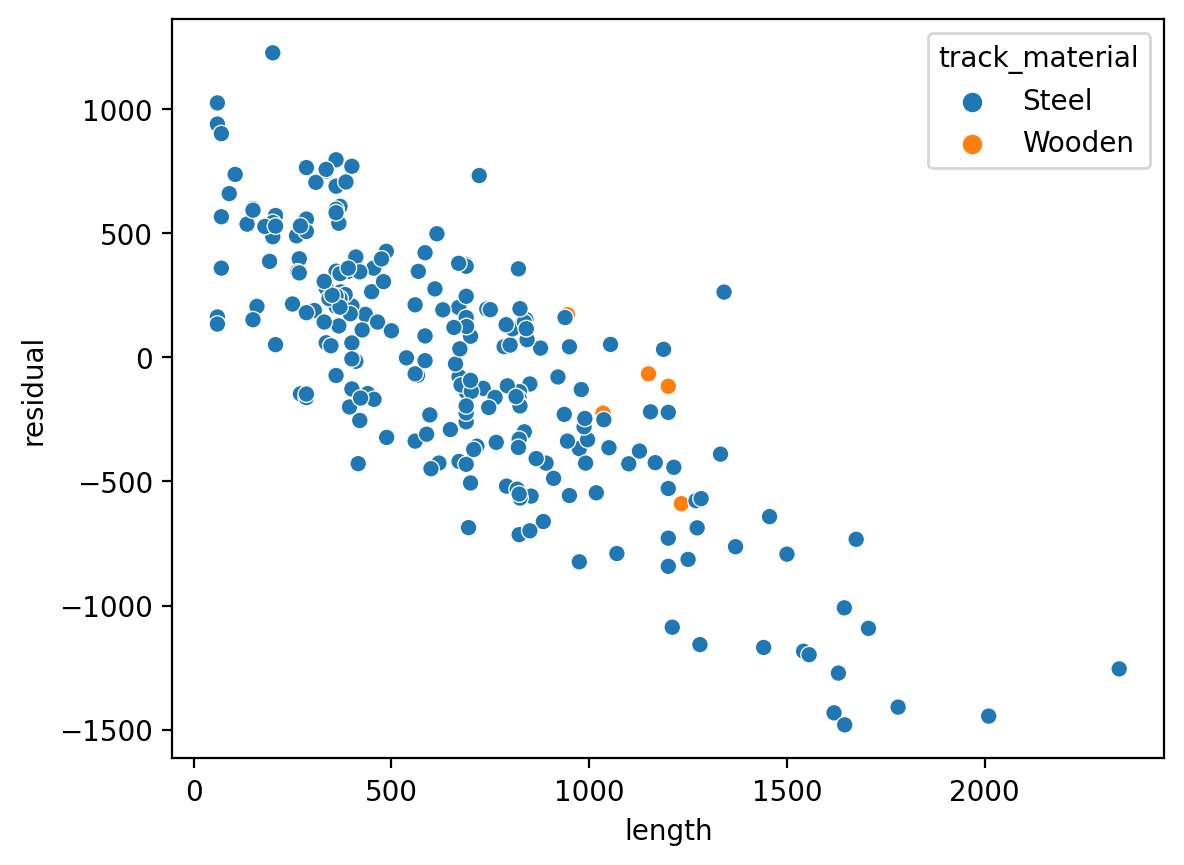

In [ ]:
reload(m)
train_steel = train[train.steel_track == 'Steel']
train_wood = train[train.steel_track == 'Wooden']
regressor_wood = LinearRegression(normalize=True)
regressor_steel = LinearRegression(normalize=True)
train_wood['y_pred'] =m.run_regression(train_wood[['speed','man_group']],regressor_wood, train_wood.length)
train_steel['y_pred'] =m.run_regression(train_steel[['speed','man_group']],regressor_steel, train_steel.length)
train = pd.concat([train_wood,train_steel]).sort_index()
train['residual'] = train.y_pred - train.length
sns.scatterplot(data=train,x='length',y='residual',hue='steel_track')

In [ ]:
root_mean_squared_error(train.length,train.y_pred)

ValueError: Input contains NaN.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 664 entries, 2381 to 619
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   name            664 non-null    object  
 1   steel_track  664 non-null    category
 2   seating_type    664 non-null    category
 3   speed           289 non-null    float64 
 4   height          289 non-null    float64 
 5   length          664 non-null    float64 
 6   num_inversions  289 non-null    float64 
 7   manufacturer    664 non-null    object  
 8   park            664 non-null    object  
 9   status          664 non-null    object  
 10  man_group       664 non-null    int64   
dtypes: category(2), float64(4), int64(1), object(4)
memory usage: 53.9+ KB


In [ ]:
reload(m)
features = ['speed','man_group']
target = 'length'
poly_scaler = PolynomialFeatures(degree=3)
scaler = RobustScaler()
trainx = train[features]
trainy = train[[target]]
validx = validate[features]
validy = validate[[target]]
scaler = RobustScaler()
strain = m.scale(trainx, scaler)
svalid = m.scale(validx,scaler)
regressor = LinearRegression()
strain = pd.DataFrame(poly_scaler.fit_transform(strain,trainy))
svalid = pd.DataFrame(poly_scaler.transform(svalid))
trainy_pred = m.run_regression(strain, regressor,trainy[target])
validy_pred = m.run_regression(svalid, regressor)
train_rmse = root_mean_squared_error(trainy[target], trainy_pred)
validate_rmse = root_mean_squared_error(validy[target], validy_pred)
ret_df = pd.DataFrame({'Train':train_rmse,'Validate':validate_rmse},index=['RMSE'])
ret_df

Train   Validate
RMSE  246.909976  287.58582

In [8]:
from sklearn.linear_model import TweedieRegressor,LassoLars
reload(m)
tv_run = lambda r,n,p=None: m.train_and_validate(train,validate,['speed','man_group','num_inversions','height'],'length',r,n,p)
m.train_and_validate(train,validate,['speed','height'],'length',LassoLars(alpha=1.0),'linreg_poly',PolynomialFeatures(3))

Train    Validate
linreg_poly  273.970303  328.986796

In [9]:
from sklearn.linear_model import TweedieRegressor
from wood_steel_regressor import WoodSteelRegression
linreg = tv_run(LinearRegression(),'Linear Regression')
linreg_square = tv_run(LinearRegression(),'Squared Regression',PolynomialFeatures(2))
linreg_cube = tv_run(LinearRegression(),'Cubed Regression',PolynomialFeatures(3))
llars = tv_run(LassoLars(alpha=2.0),'LASSO+LARS')
llars_square = tv_run(LassoLars(alpha=2.0),'LASSO+LARS^2',PolynomialFeatures(2))
llars_cube = tv_run(LassoLars(alpha=2.0),'LASSO+LARS^3',PolynomialFeatures(3))
glm = tv_run(TweedieRegressor(power=1,alpha=1),'GLM')
glm_square = tv_run(TweedieRegressor(power=1,alpha=1),'GLM^2',PolynomialFeatures(2))
glm_cube = tv_run(TweedieRegressor(power=1,alpha=1),'GLM^3',PolynomialFeatures(3))
linreg_ws = tv_run(WoodSteelRegression(LinearRegression(),LinearRegression),'Wood/Steel Regression')
linreg_ws_square = tv_run(WoodSteelRegression(LinearRegression(),LinearRegression),'Wood/Steel Regression',PolynomialFeatures(2))
pd.concat([linreg,linreg_square,linreg_cube,llars,llars_square,llars_cube,glm,glm_square,glm_cube,linreg_ws])

Train    Validate
Linear Regression      264.933973  320.202225
Squared Regression     249.172382  295.400013
Cubed Regression       231.309010  300.265153
LASSO+LARS             264.933973  320.202225
LASSO+LARS^2           249.172382  295.400013
LASSO+LARS^3           231.309010  300.265153
GLM                    264.933973  320.202225
GLM^2                  249.172382  295.400013
GLM^3                  231.309010  300.265153
Wood/Steel Regression  264.815364  324.369853

In [ ]:
changes = ['Orion','Ice Breaker','Velocicoaster','Texas Stingray','Namazu','Escape from Madagascar']
coaster_df[coaster_df.name.isin(changes)]

name steel_track seating_type   speed  height  \
393   Escape from Madagascar          Steel    Suspended   42.00   15.00   
2591                   Orion          Steel     Sit Down  146.45   87.48   
2592             Ice Breaker          Steel     Sit Down   83.69   28.35   
2601                  Namazu          Steel     Sit Down   84.49   15.85   
2668          Texas Stingray          Steel     Sit Down   88.51   30.48   
2669           Velocicoaster          Steel     Sit Down  112.65   47.24   

       length  num_inversions   manufacturer  \
393    342.00             0.0         Vekoma   
2591  1621.84             0.0            B&M   
2592   579.12             0.0  Premier Rides   
2601   584.00             0.0        Intamin   
2668  1029.92             0.0            GCI   
2669  1432.56             4.0        Intamin   

                                       park            status  
393                              Dreamworld  status.operating  
2591                           Kings Island         operating  
2592                       SeaWorld Orlando         operating  
2601                               Vulcania         operating  
2668                   SeaWorld San Antonio         operating  
2669  Universal StudiosIslands of Adventure         operating

In [ ]:
poly = PolynomialFeatures(2)
poly.fit_transform(train[['speed','height']],train.length)

array([[1.000e+00, 8.500e+01, 3.500e+01, 7.225e+03, 2.975e+03, 1.225e+03],
       [1.000e+00, 7.000e+01, 2.000e+01, 4.900e+03, 1.400e+03, 4.000e+02],
       [1.000e+00, 8.000e+01, 3.200e+01, 6.400e+03, 2.560e+03, 1.024e+03],
       ...,
       [1.000e+00, 9.800e+01, 2.700e+01, 9.604e+03, 2.646e+03, 7.290e+02],
       [1.000e+00, 4.500e+01, 1.500e+01, 2.025e+03, 6.750e+02, 2.250e+02],
       [1.000e+00, 4.000e+01, 1.500e+01, 1.600e+03, 6.000e+02, 2.250e+02]])

In [12]:
from itertools import product
names = product(['lr','tw','ll'],repeat=2)
for n in names:
    print(n)

('lr', 'lr')
('lr', 'tw')
('lr', 'll')
('tw', 'lr')
('tw', 'tw')
('tw', 'll')
('ll', 'lr')
('ll', 'tw')
('ll', 'll')


In [40]:
m.try_models_train_validate(train,validate).sort_values(by=['Validate','Train'])

Train    Validate
Squared Regression  249.172382  295.400013
LASSO+LARS^2        249.172382  295.400013
GLM^2               249.172382  295.400013
Cubed Regression    231.309010  300.265153
LASSO+LARS^3        231.309010  300.265153
GLM^3               231.309010  300.265153
Linear Regression   264.933973  320.202225
LASSO+LARS          264.933973  320.202225
GLM                 264.933973  320.202225

In [39]:
reload(m)
m.wood_steel_permutations(train,validate).sort_values(by=['Validate','Train'])

Train    Validate
lr_lr_2  249.172382  295.400013
lr_ll_2  249.172382  295.400013
lr_tw_2  249.172382  295.400013
ll_lr_2  249.172382  295.400013
ll_ll_2  249.172382  295.400013